In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2022-10-20 14:28:45--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 2404:6800:4009:821::200e, 142.250.182.238
Connecting to drive.google.com (drive.google.com)|2404:6800:4009:821::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kl2jlj6v94d7smtnm3pooj9h4q0q41tg/1666256325000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=cec485c7-706b-4abd-a304-00fbc68a7033 [following]
--2022-10-20 14:28:52--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kl2jlj6v94d7smtnm3pooj9h4q0q41tg/1666256325000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=cec485c7-706b-4abd-a304-00fbc68a7033
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 2404:6800:4009:82e::2001, 142.250.67.129
Connecting to doc-

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


In [5]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 20s 12ms/step - loss: 5.9771 - accuracy: 0.0465
Epoch 2/100
1480/1480 [==============================] - 15s 10ms/step - loss: 5.6605 - accuracy: 0.0525
Epoch 3/100
1480/1480 [==============================] - 15s 10ms/step - loss: 5.4535 - accuracy: 0.0756
Epoch 4/100
1480/1480 [==============================] - 16s 11ms/step - loss: 5.2793 - accuracy: 0.0978
Epoch 5/100
1480/1480 [==============================] - 16s 11ms/step - loss: 5.1252 - accuracy: 0.1138
Epoch 6/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.9633 - accuracy: 0.1293
Epoch 7/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.7953 - accuracy: 0.1450
Epoch 8/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.6489 - accuracy: 0.1609
Epoch 9/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.5157 - accuracy: 0.1758
Epoch 10/100
1480/1480 [==============================]

1480/1480 [==============================] - 16s 11ms/step - loss: 2.5715 - accuracy: 0.4552
Epoch 79/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5741 - accuracy: 0.4556
Epoch 80/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5587 - accuracy: 0.4598
Epoch 81/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5419 - accuracy: 0.4624
Epoch 82/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5323 - accuracy: 0.4630
Epoch 83/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5382 - accuracy: 0.4638
Epoch 84/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5152 - accuracy: 0.4657
Epoch 85/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.5014 - accuracy: 0.4688
Epoch 86/100
1480/1480 [==============================] - 16s 11ms/step - loss: 2.4961 - accuracy: 0.4706
Epoch 87/100
1480/1480 [==============================] - 1

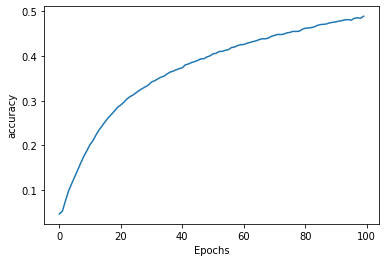

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

im feeling chills me to pay the time that i miss you life think were down and tell me that impatiently its my dreams took a heart set everythings slipping working working cryin lights same ass chance ahhah honey affair sleeping citys bright toy me down into those in want else did reading me that bought clothes will heal and use daddy he kong soul bright away filled trough man goes with mean you arrive it died rikky visitors prepared me fashioned pain to pay piece loud day real dancing fashioned hero clouds sunrise black man yellow piper lights man passing now i


## Varying the Possible Outputs

In [10]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

425


In [17]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills again cause its only free to survive in me blue years scene shy and having beast of songs jive headline hallelujah its sincere darling gently days away among anyway awhile cinderella been in a diddle champagne cryin knew yet can suddenly be waterloo to god leave them ago tune supernatural its piece reading tails scars this heels and surely million to walk with the weak for you treat right chasing up in knife darling needs a warning unknown harder touch nine days ten hurry hardly feelin hardly bang roller hardly pass the bit of movie spin figure figure figure forever
